In [4]:
%load_ext autoreload
%autoreload 2

from df2d.model import Drosophila2DPose
from df2d.parser import create_parser
import torch

checkpoint_path = '/home/user/Desktop/DeepFly3D/weights/sh8_deepfly.tar'
args = create_parser().parse_args('')
model = Drosophila2DPose(checkpoint_path=checkpoint_path, **args.__dict__).cuda()

In [5]:
from df2d.inference import path2inp
from df2d.dataset import Drosophila2Dataset
from torch.utils.data import DataLoader

image_path = '/home/user/Desktop/DeepFly3D/data/test/'
inp = path2inp(image_path) # extract list of images under the folder
dat = DataLoader(Drosophila2Dataset(inp), batch_size=8)

In [1]:
%%time
from df2d.inference import inference
points2d = inference(model, dat)

NameError: name 'model' is not defined

In [75]:
!ls /mnt/NAS/JB/200814_G23xU14/Fly001/001_xz_teststim/behData/images

camera_0.mp4  camera_2.mp4  camera_4.mp4  camera_6.mp4
camera_1.mp4  camera_3.mp4  camera_5.mp4  capture_metadata.json


In [3]:
%load_ext autoreload
%autoreload 2
from df2d.inference import inference_folder
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
#image_path = '/home/user/Desktop/DeepFly3D/data/test/camera_{cam_id}_img_00000{img_id}.jpg'
#image_path = '/data/df3d/180919_MDN_PR/Fly5/001_SG1/behData/images/camera_{cam_id}_img_{img_id:06d}.jpg'
image_path = '/mnt/NAS/FA/200910_G23xU1/Fly2/001_coronal/behData/images/camera_{cam_id}_img_{img_id}.jpg'
calib = pickle.load(open('weights/calib__home_user_Desktop_DeepFly3D_data_test.pkl', 'rb'))
#cam_order = [0, 1, 2, 3, 4, 5, 6]
cam_order = np.array([6, 5, 4, 3, 2, 1, 0])

In [41]:
import matplotlib.pyplot as plt
from df2d.inference import parse_img_path

class load_f:
    def __init__(self, cam_order):
        self.cam_order = cam_order.tolist()
    def __call__(self, x):
        img = plt.imread(x)
        cam_id, _ = parse_img_path(x)
        if self.cam_order.index(cam_id) > 3:
            img = img[:, ::-1]
        return img

In [47]:
points2d = inference_folder('/mnt/NAS/FA/200910_G23xU1/Fly2/001_coronal/behData/images/', load_f = load_f(cam_order), max_img_id=50)

100%|██████████| 45/45 [00:20<00:00,  2.19it/s]


In [48]:
from pyba.CameraNetwork import CameraNetwork
from pyba.config import df3d_bones, df3d_colors

In [49]:
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyba.CameraNetwork import CameraNetwork
import numpy as np

# 2d pose estimation outputs 19 points, which is what a single camera sees,
#     however there are 38 joints in total
points2d_cp = np.zeros((points2d.shape[0], points2d.shape[1], points2d.shape[2]*2, 2))
points2d_cp[cam_order[:3], :, :19] = points2d[cam_order[:3]]
points2d_cp[cam_order[4:], :, 19:] = points2d[cam_order[4:]]

# (x,y) are switched in pyba coordinate system, so we need to swap last two axes
tmp = np.copy(points2d_cp[..., 0])
points2d_cp[..., 0] = points2d_cp[..., 1]
points2d_cp[..., 1] = tmp

# 2 and 4 cannot see the stripes
points2d_cp[cam_order[2], :, 15:] = 0 
points2d_cp[cam_order[4], :, 19+15:] = 0

# flip lr back left-hand-side cameras
for cidx in [4,5,6]:
    points2d_cp[cam_order[cidx], ..., 0] = 1 - points2d_cp[cam_order[cidx], ..., 0]

In [50]:
import pickle

# for cam order [6,5,4,...], camera 6 should get the calibration of the camera 0
calib_reordered = {cidx: calib[idx] for (idx, cidx) in enumerate(cam_order)} # 
camNet = CameraNetwork(points2d_cp*[960, 480], image_path=image_path, bones=df3d_bones, colors=df3d_colors, calib=calib_reordered)

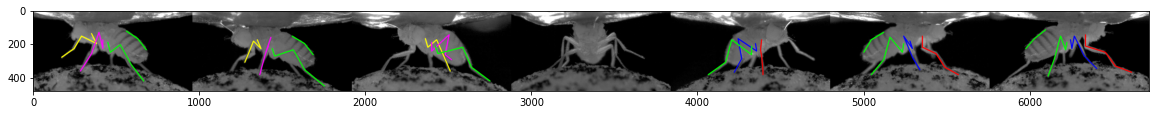

In [51]:
import matplotlib.pyplot as plt
cid, img_id = 0, 0
plt.figure(figsize=(20,20))
img = camNet.plot_2d(0)
plt.imshow(img)

In [52]:
camNet.reprojection_error()

[6.191417827265116,
 8.464887540672235,
 4.279040133678975,
 0.0,
 4.58693930312665,
 5.9302258336436395,
 8.278228890169515]

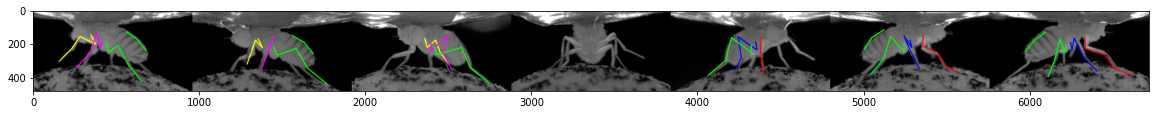

In [53]:
import matplotlib.pyplot as plt
cid, img_id = 0, 0
plt.figure(figsize=(20,20))
img = camNet.plot_2d(0, points='reprojection')
plt.imshow(img)

In [48]:
camNet.bundle_adjust(update_intrinsic=False, update_distort=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8385e+06                                    9.23e+05    
       1              2         1.4787e+06      3.60e+05       7.62e+00       3.49e+05    
       2              3         1.4771e+06      1.64e+03       6.89e-01       1.04e+04    
       3              4         1.4771e+06      2.72e+01       7.06e-02       6.05e+03    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.8385e+06, final cost 1.4771e+06, first-order optimality 6.05e+03.


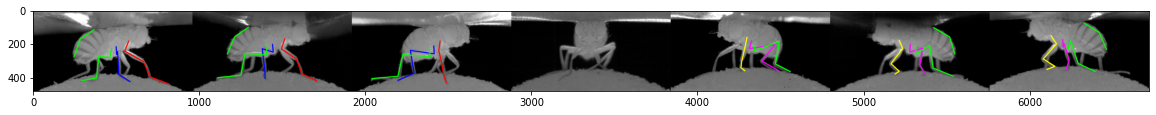

In [47]:
import matplotlib.pyplot as plt
cid, img_id = 0, 0
plt.figure(figsize=(20,20))
img = camNet.plot_2d(0, points='reprojection')
plt.imshow(img)

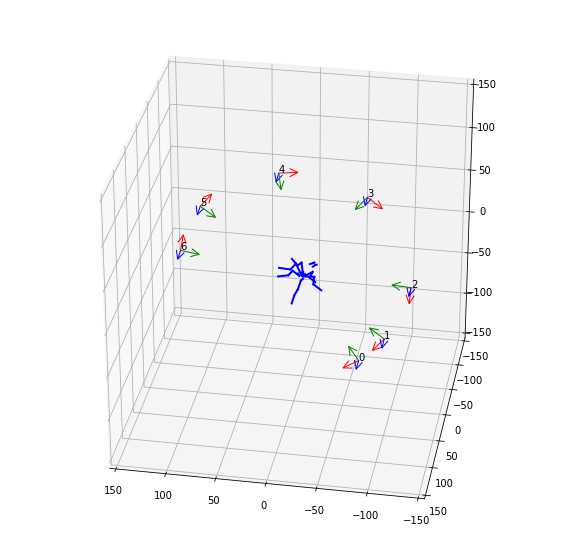

In [30]:
fig = plt.figure(figsize=(10,10))
ax3d = fig.add_subplot(111, projection='3d')
camNet.draw(ax3d, size=20)
camNet.plot_3d(ax3d, img_id=0, size=10)
plt.xlim([-150, 150])
plt.ylim([-150, 150])
ax3d.set_zlim([-150, 150])

ax3d.view_init(30,100)